Singleton implementation

In [30]:
pip install asyncpg

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/621.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/621.1 kB ? eta -:--:--
   ---------------------------------------- 621.1/621.1 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch.nn as nn

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(128*10*10*10, 256)  # Adjust size based on input
        self.fc2 = nn.Linear(256, 10)  # Example 10-class classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = Simple3DCNN()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(10):  # Example: 10 epochs
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

NameError: name 'data_loader' is not defined

In [11]:
import os
import cv2
#import mediapipe as mp
import urllib.request
from gluoncv.model_zoo import get_model
model_name = 'i3d_inceptionv1_kinetics400'
net = get_model(model_name, nclass=400, pretrained=True)
print('%s model is successfully loaded.' % model_name)
print(f"Vidéo annotée sauvegardée à : {output_path}")

RuntimeError: Legacy torch==2.6.0+cpu detected, some modules may not work properly. torch>=1.4.0,<2.0.0 is required. You can use pip or conda to upgrade

In [10]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

NameError: name 'model' is not defined

Durée : 139.32 sec, Taux : 44100 Hz


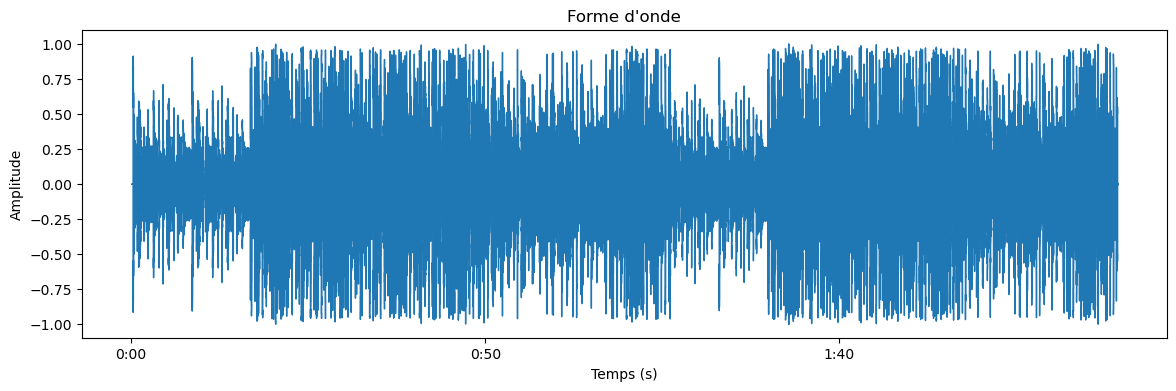

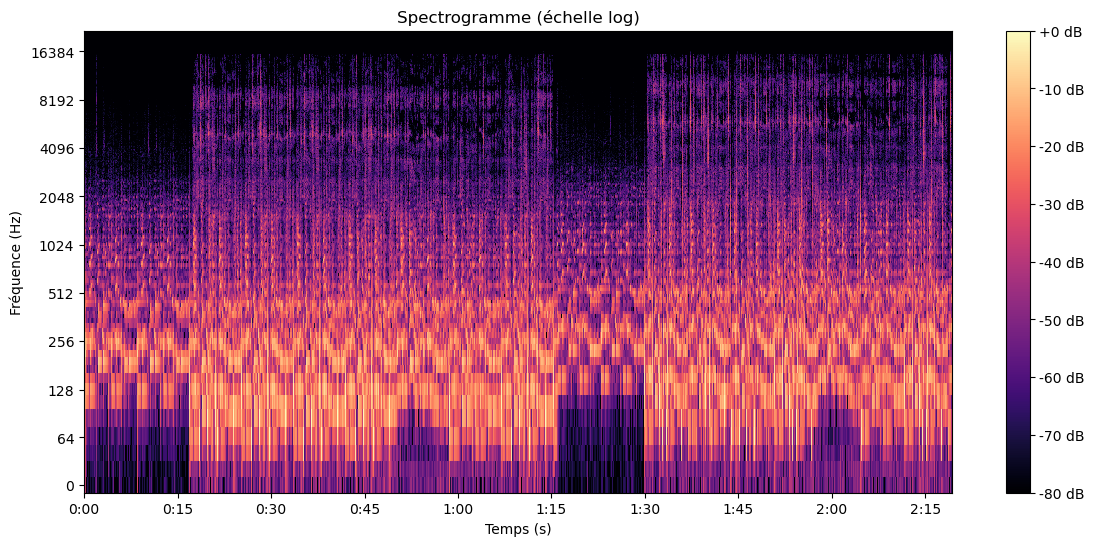

Coefficients d'ondelettes sauvegardés dans wavelet_features.csv


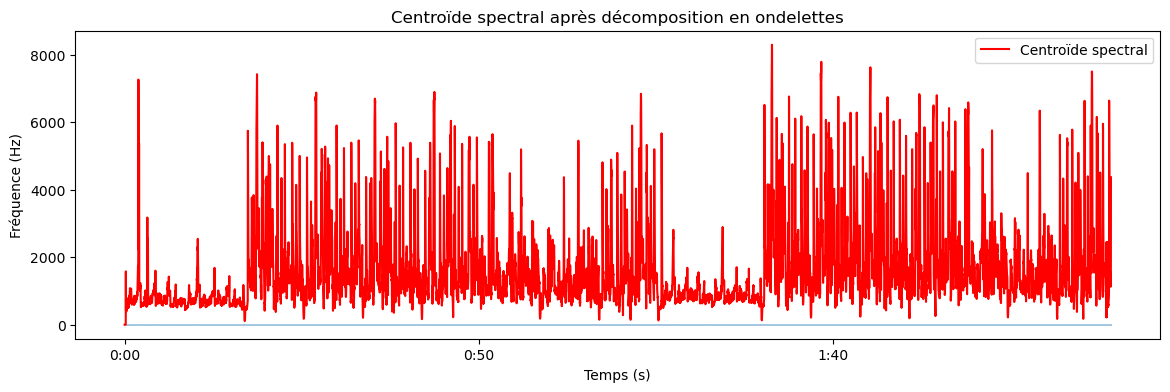

In [13]:
import numpy as np
import librosa
import librosa.display
import pywt
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

def apply_wavelet_transform(y, wavelet="db4", level=5):
    """Applique une décomposition en ondelettes et retourne les coefficients normalisés"""
    coeffs = pywt.wavedec(y, wavelet, level=level)
    coeffs = [c / np.max(np.abs(c)) if np.max(np.abs(c)) != 0 else c for c in coeffs]
    return coeffs

def plot_waveform(y, sr):
    """Visualisation de la forme d'onde audio"""
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Forme d'onde")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(y, sr):
    """Visualisation du spectrogramme"""
    S = np.abs(librosa.stft(y))
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogramme (échelle log)")
    plt.xlabel("Temps (s)")
    plt.ylabel("Fréquence (Hz)")
    plt.show()

def extract_spectral_centroid(y, sr):
    """Extraction et visualisation des centroïdes spectraux"""
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    t = librosa.frames_to_time(range(len(spectral_centroids)), sr=sr)

    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, spectral_centroids, color='r', label="Centroïde spectral")
    plt.title("Centroïde spectral après décomposition en ondelettes")
    plt.xlabel("Temps (s)")
    plt.ylabel("Fréquence (Hz)")
    plt.legend()
    plt.show()

    return spectral_centroids

def save_wavelet_coeffs(coeffs, filename="wavelet_features.csv"):
    """Sauvegarde des coefficients d'ondelettes dans un fichier CSV"""
    df = pd.DataFrame(coeffs).T
    df.to_csv(filename, index=False)
    print(f"Coefficients d'ondelettes sauvegardés dans {filename}")

def visualize_audio_features(audio_path):
    """Pipeline complet d'analyse audio"""
    y, sr = librosa.load(audio_path, sr=None)
    print(f"Durée : {librosa.get_duration(y=y, sr=sr):.2f} sec, Taux : {sr} Hz")

    plot_waveform(y, sr)
    plot_spectrogram(y, sr)

    coeffs = apply_wavelet_transform(y)
    save_wavelet_coeffs(coeffs)

    spectral_centroid = extract_spectral_centroid(y, sr)

if __name__ == "__main__":
    audio_file = "Vluestar & Shiloh Dynasty - I’ll Keep You Safe (Lyrics).wav"
    visualize_audio_features(audio_file)

In [1]:
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable
  Using cached mediapipe-0.10.21-cp312-cp312-win_amd64.whl.metadata (10 kB)
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp312-cp312-win_amd64.whl.metadata (1.2 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached sounddevice-0.5.1-py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp312-cp312-win_amd64.whl.metadata (8.3 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
Using cached mediapipe-0.10.21-cp312-cp312-win_amd64.whl (51.0 MB)
Using cached sounddevice-0.5.1-py3-none-win_amd64.whl (363 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\ana

In [67]:
import psycopg2

# Connexion à la base de données
conn = psycopg2.connect(
    dbname="Agenda",
    user="postgres",
    password="0000",
    host="localhost",
    port="5432"
)

# Création d'un curseur pour exécuter les requêtes SQL
cur = conn.cursor()

# Exemple : Création d'une table
cur.execute("""
    CREATE TABLE IF NOT EXISTS utilisateurs1 (
        id SERIAL PRIMARY KEY,
        nom VARCHAR(100),
        email VARCHAR(100) UNIQUE
    )
""")
conn.commit()  # Appliquer les modifications

# Insérer des données
cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("Alice", "alice@example.com"))
conn.commit()

# Récupérer des données
cur.execute("SELECT * FROM gps_data")
rows = cur.fetchall()
for row in rows:
    print(row)

# Fermer la connexion
cur.close()
conn.close()


(1, 48.8566, 2.3522, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(2, 51.5074, -0.1278, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(3, 40.7128, -74.006, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(4, -33.8688, 151.2093, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(5, 35.6895, 139.6917, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(6, 55.7558, 37.6173, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(7, -34.6037, -58.3816, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(8, 39.9042, 116.4074, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(9, 28.6139, 77.209, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(10, 19.076, 72.8777, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(11, 37.7749, -122.4194, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(12, 34.0522, -118.2437, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(13, 41.9028, 12.4964, datetime.datetime(2024, 12, 13, 11, 21, 15, 256544))
(14, 48.2082, 

In [1]:
class singleton:
    _instance = 'juan'
    @staticmethod
    def getInstance():
        if singleton._instance == 'juan':
            singleton()
        return singleton._instance
    def __init__(self):
        if singleton._instance != 'juan':
            raise Execption("oula")
        else:
            singleton._instance = self
if __name__ == "__main__":
    objet = singleton()
    print(objet)
    objet = singleton.getInstance()
    print(objet)

In [76]:
class user:
    _instance = None
    
    @staticmethod
    def getInstance():
        if user._instance == None:
            user()
        return user._instance

    
# enregistrement des information
    def enregistrement():
        println("entrez votre nom >")
        self.name = input(" > ... ")
        println("entrez votre age >")
        self.name = input(" > ... ")


# affichage des information
    def affichage ():
        print(f"Nom: {self.nom}, Age: {self.age}")


# verrification des information
    def verification():
        if self.nom == None or self . age == None:
            print(f"{'nome' if not self.name else 'age'} est vide." if not self.name or not self.age else True)


# menus repetitif
    def menus():
        while True:
            case = input("entrez > 1 < pour commencer ou q r>")
            if case == 'q':
                print("incroyable ... non mais vraiment")
                print(f"{user.getInstance}")
                break
            elif case == '1':
                print(f"{user.getInstance}")
                nom = input ("entrez le nom").strip()
                case = input("entrez > 1 < pour continuer ou q mais tu peut t'arreter la O __ O >")
                if case == 'q':
                    print("incroyable ... non mais vraiment")
                    print(f"{user.getInstance}")
                    break
                age = input ("entrez le age").strip()
                case = input("entrez > 1 < pour continuer ou q ")
                #print("tu peut aussi afficher si tu veut, si tu tape 1 ....  O __ O .... noublis pa que tu peut t'arreter - __ -")
                if case == 'q':
                    print("incroyable ... non mais vraiment")
                    print(f"{user.getInstance}")
                    break
                case = input("entrez > 1 < pour continuer ou q ")
                #print(f"Nom: {nom}, Age: {age}")
            else: 
                print(f"sereiusement ... t'as vraiment taper ca ... ")
        
            
# fonction d'initialisation
    def __init__(self):
        self.nom = None
        self.age = None

# gestion de l'exception pour eviter de cree une seconde instance ou pas
        if user._instance != None:
            raise Exception("oula")
        else:
            user._instance = self
        
        
# execution
if __name__ == "__main__":
    
# creation du singleton
    objet = user()
    print(objet)
    user.menus()
    
# utilisation du menu

# recuperation de l'instance
    objet = user.getInstance()
    print(objet)

    

# creation de la seconde instance pour verification
    #objet1 = user()
    #print(objet1)

            

SyntaxError: invalid syntax (3710131829.py, line 25)

In [5]:
def menus():
        
        while True:
            case = input("entrez > 1 < pour commencer ou q rien a foutre de toute facon >")
            if case == 'q':
                print("incroyable ... non mais vraiment")
                break
            elif case == '1':
                nom = input ("entrez le nom").strip()
                case = input("entrez > 1 < pour continuer ou q mais tu peut t'arreter la O __ O >")
                age = input ("entrez le age").strip()
                case = input("entrez > 1 < pour continuer ou q la aussi c'est bien O __ O  ..... s'arrerter .... >")
                print("tu peut aussi afficher si tu veut, si tu tape 1 ....  O __ O .... noublis pa que tu peut t'arreter - __ -")
                case = input("entrez > 1 < pour continuer ou q la aussi c'est bien O __ O  ..... s'arrerter .... >")
                print(f"Nom: {nom}, Age: {age}")
            else: 
                print(f"sereiusement ... t'as vraiment taper ca ... ")

menus()


entrez > 1 < pour commencer ou q rien a foutre de toute facon > 1
entrez le nom juan
entrez > 1 < pour continuer ou q mais tu peut t'arreter la O __ O > 1
entrez le age 47
entrez > 1 < pour continuer ou q la aussi c'est bien O __ O  ..... s'arrerter .... > 1


tu peut aussi afficher si tu veut, si tu tape 1 ....  O __ O .... noublis pa que tu peut t'arreter - __ -
Nom: juan, Age: 47


entrez > 1 < pour commencer ou q rien a foutre de toute facon > q


incroyable ... non mais vraiment


In [60]:
class SQLQuery:
    def __init__(self, table):
        self.table = table
        self.columns = '*'
        self.conditions = []
        self.group_by = []
        self.order_by = []

############################################################
    # ajouter les methode supplementaire ici

    # methode select
    def method_select(self, columns):
        self.columns = ', '.join(columns)
        return self
        
    #methode insert
    def method_insert(self,columns):
        self.columns = ', '.join(columns)
        return self
    
###############################################################
    #methode where
    def method_where(self, condition):
        self.conditions.append(condition)
        return self

# espace pour les clause
    # clause 1
    def method_group_by(self, columns):
        self.group_by.extend(columns)
        return self
    #clause 2
    def method_order_by(self, columns):
        self.order_by.extend(columns)
        return self
        
    

    # factory method select
    def build_query(self):
        query = f"SELECT {self.columns} FROM {self.table}"
        if self.conditions:
            query += f" WHERE {' AND '.join(self.conditions)}"
        if self.method_group_by:
            query += f" GROUP BY {', '.join(self.group_by)}"
        if self.method_order_by:
            query += f" ORDER BY {', '.join(self.order_by)}"
        return query + ";"
        
    # factory insert:
    def build_insert_query(self, values):
        # Assurez-vous que le nombre de valeurs correspond au nombre de colonnes
        if len(values) != len(self.columns.split(", ")):
            raise ValueError("nombre de collonne non correspondant")

         self.columns = ', '.join(columns)  # Définir les colonnes
         self.values = values  # Stocker les valeurs
         return self
        

In [61]:
class SQLQueryFactory:
    @staticmethod
    def create_query(table):
        return SQLQuery(table)


In [70]:
import psycopg2

#fonction pour executer les requettes
def executer_requete(query, conn_params):
    try:
        #connection
        conn = psycopg2.connect(**conn_params)
        cursor = conn.cursor()

        #execution
        cursor.execute(query)
        resultats = cursor.fetchall()

        #fermeture
        cursor.close()
        conn.close()

        return resultats

    except Exception as e:
        print("Erreur  :", e)
        return None

if __name__ == "__main__":

    #connection  a la base de donnee postgres
    conn_params = {
        'dbname': 'Agenda',
        'user': 'postgres',
        'password': '0000',
        'host': 'localhost',
        'port': 5432
    }

    query = (SQLQueryFactory.create_query('gps_data')
             .method_select(['latitude, longitude'])
             .method_where("latitude > 30")
             .method_group_by(['latitude,longitude'])
             .method_order_by(['latitude'])
             .build_query())

    print("Requête générée :", query)

    resultats = executer_requete(query, conn_params)
    if resultats:
        for ligne in resultats:
            print(ligne)


Requête générée : SELECT latitude, longitude FROM gps_data WHERE latitude > 30 GROUP BY latitude,longitude ORDER BY latitude;
(31.2304, 121.4737)
(34.0522, -118.2437)
(35.6895, 139.6917)
(37.7749, -122.4194)
(39.9042, 116.4074)
(40.7128, -74.006)
(41.9028, 12.4964)
(43.6532, -79.3832)
(45.4642, 9.19)
(48.2082, 16.3738)
(48.8566, 2.3522)
(51.5074, -0.1278)
(52.52, 13.405)
(55.7558, 37.6173)


In [56]:
#quelque ajouts
conn = psycopg2.connect(
    dbname="Agenda",
    user="postgres",
    password="0000",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("juan", "juan@gmail.com"))
cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("juan1", "juan1@gmail.com"))
cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("juan2", "juan2@gmail.com"))
cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("juan3", "juan3@gmail.com"))
cur.execute("INSERT INTO utilisateurs1 (nom, email) VALUES (%s, %s)", ("juan4", "juan4@gmail.com"))

conn.commit()

In [75]:
import psycopg2

class SQLQuery:
    def __init__(self, table):
        self.table = table
        self.columns = '*'
        self.conditions = []
        self.group_by = []
        self.order_by = []
        self.values = None  
        self.query_type = 'SELECT' 

    #methode select
    
    def methode_select(self, columns):
        self.query_type = 'SELECT'
        self.columns = ', '.join(columns)
        return self
        
    #methode insert
    def methode_insert(self, columns, values):
        if len(columns) != len(values):
            raise ValueError("nombre de collonne non correspondants")
        
        self.query_type = 'INSERT'
        self.columns = ', '.join(columns)
        self.values = values
        return self

    #methode delete 
    def methode_delete(self, columns):
        self.query_type = 'DELETE'
        self.columns = ', '.join(columns)
        return self

    #condition where
    def methode_where(self, condition):
        self.conditions.append(condition)
        return self

    #clause group by
    def methode_group_by(self, columns):
        self.group_by.extend(columns)
        return self

    #clause order by
    def methode_order_by(self, columns):
        self.order_by.extend(columns)
        return self

    #implementation des requettes
    def build_query(self):
        if self.query_type == 'SELECT':
            query = f"SELECT {self.columns} FROM {self.table}"
            if self.conditions:
                query += f" WHERE {' AND '.join(self.conditions)}"
            if self.group_by:
                query += f" GROUP BY {', '.join(self.group_by)}"
            if self.order_by:
                query += f" ORDER BY {', '.join(self.order_by)}"
            return query + ";"
        
        elif self.query_type == 'INSERT':
            if self.values is None:
                raise ValueError("Aucune valeur spécifiée pour l'insertion")
            
            formatted_values = ", ".join([f"'{value}'" for value in self.values])
            return f"INSERT INTO {self.table} ({self.columns}) VALUES ({formatted_values});"
            
        elif self.query_type == 'DELETE':
            query = f" DELETE FROM {self.table}"
            if self.conditions:
                query += f"WHERE {' '.join(self.condition)}"
            return query + ";"

        else:
            raise ValueError("Type de requête non pris en charge")
            
#implementation du builder
class SQLQueryFactory:
    @staticmethod
    def create_query(table):
        return SQLQuery(table)

#execution des 
def executer_requete(query, conn_params, is_select=True):
    try:
        conn = psycopg2.connect(**conn_params)
        cursor = conn.cursor()

        cursor.execute(query)
        
        if is_select:
            resultats = cursor.fetchall()
        else:
            conn.commit() 

        cursor.close()
        conn.close()

        return resultats if is_select else None

    except Exception as e:
        print("Erreur :", e)
        return None

# Exécution principale
if __name__ == "__main__":
    conn_params = {
        'dbname': 'Agenda',
        'user': 'postgres',
        'password': '0000',
        'host': 'localhost',
        'port': 5432
    }

    insert_query = (SQLQueryFactory.create_query('gps_data')
                    .methode_+insert(['latitude', 'longitude'], [45.678, -73.456])
                    .build_query())

    print("Requête générée pour INSERT :", insert_query)
    executer_requete(insert_query, conn_params, is_select=False)

    select_query = (SQLQueryFactory.create_query('gps_data')
                    .methode_select(['latitude', 'longitude'])
                    .methode_where("latitude > 30")
                    .methode_group_by(['latitude', 'longitude'])
                    .methode_order_by(['latitude'])
                    .build_query())

    print("Requête générée pour SELECT :", select_query)
    resultats = executer_requete(select_query, conn_params, is_select=True)

    if resultats:
        for ligne in resultats:
            print(ligne)


Requête générée pour INSERT : INSERT INTO gps_data (latitude, longitude) VALUES ('45.678', '-73.456');
Requête générée pour SELECT : SELECT latitude, longitude FROM gps_data WHERE latitude > 30 GROUP BY latitude, longitude ORDER BY latitude;
(31.2304, 121.4737)
(34.0522, -118.2437)
(35.6895, 139.6917)
(37.7749, -122.4194)
(39.9042, 116.4074)
(40.7128, -74.006)
(41.9028, 12.4964)
(43.6532, -79.3832)
(45.4642, 9.19)
(45.678, -73.456)
(48.2082, 16.3738)
(48.8566, 2.3522)
(51.5074, -0.1278)
(52.52, 13.405)
(55.7558, 37.6173)


Factory pattern

In [7]:
class Enfant:
    def description(self):
        return "Enfant "

class JeuneAdulte:
    def description(self):
        return "Jeune Adulte"

class Adulte:
    def description(self):
        return "Adulte"

class PersonneFactory:
    @staticmethod
    def get_class(age):
        if 1 <= age <= 9:
            return Enfant()
        elif 10 <= age <19:
            return JeuneAdulte()
        elif age >= 20:
            return Adulte()
        else:
            raise ValueError("L'age doit etre positif et superieur a 0")

try:
    age = int(input("entrez votre age: "))
    person = PersonneFactory.get_class(age)
    print("vous apaertener a la categorie: ",  person.description())
except ValueError as e:
    print("Erreur : ", e)

entrez votre age:  45


vous apaertener a la categorie:  Adulte


Prototype

In [11]:
import time
import copy
class Map():
    _intance = None
    @staticmethod
    def __init__(self):
        if (_intance == None):
            print("chargement de la map en cour...")
            time.sleep(10)
            #self.data = data
            print("chargement terminer")
            Map()
        else:
            copy.deepcopy(self)
            Map()
    

    def clone (self):
        return copy.deepcopy(self)

print("creation de la map")
map = Map()

print("\n clonnage de la map...")
map1 = map.clone()
print("clonage terminer")
map1 = Map()
print("dkdkdkd")


Création de la première map :
Chargement de la map en cours...
Chargement terminé

Création de la deuxième map :
Création d'une nouvelle map (instantanée)


In [14]:
import time
import copy
class Map():
    _instance = False
    #@staticmethod
    def __init__(self):
        if not Map._instance :
            print("chargement de la map en cour...")
            time.sleep(10)
            print("chargement terminer")
            Map._instance = True
        else:
            print(" creation de la seconde map")
            print("terminer")
    


print("creation de la map")
map = Map()
map1 = Map()
map2 = Map()




creation de la map
chargement de la map en cour...
chargement terminer
 creation de la seconde map
terminer
 creation de la seconde map
terminer


Proxy

In [30]:
class Nombres:
    #self.liste1 = []

    #method inter
    def __iter__(self):
        self.liste = []
        return self

    
    #class proxy
    def Proxy(liste1):
        for i in liste1:
            if i % n == 0:
                self.liste.append(i)

    #method add into list
    def add_list(n):
        Nombre.liste.append(n)
'''
    #print the liste
    def Liste_pair(self.liste1):
        for i in liste1:
            print(f"les nombres pair sont {i}")'''

#debut du main
n1 = Nombre()

liste1 = []
while (True):
    case = input("entrez 1 pour continuer et apuyer sur q pour terminer")
    if case == 1:
        n = input("entrer un nombre -> ")
        add_list(n)
        #add_list(n)
        case = int(input("entrez 1 pour continuer et apuyer sur q pour terminer"))
        proxy(liste1)
        for a in liste1:
            print(a)
        if case == 0:
            proxy(liste1)
            break
        
        
        
        

entrez 1 pour continuer et apuyer sur q pour terminer 1
entrez 1 pour continuer et apuyer sur q pour terminer 2
entrez 1 pour continuer et apuyer sur q pour terminer 4
entrez 1 pour continuer et apuyer sur q pour terminer 5


KeyboardInterrupt: Interrupted by user

In [13]:
array = []
array.append(4)
array.append(44)
print(array) 

[4, 44]


In [ ]:
class Nombres:

    def __init__(self):
        self.liste = []
        self.liste1 = []
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self,x):
        if self.index < len(self.liste):
            item = self.liste[self.index]
            self.index += 1
            return item
        else:
            raise StopIteration
            

    def proxy():
        for i in self.liste:
            if i % 2 == 0:
                self.liste1.append(i)
        return liste1
            
        
        
a = Nombres()
b = iter(a)
print(next(b))
'''
while True:
    a = input("entrer un nombre")
    b = iter(a)
    print(next(b))
    if a == 'q' :
        break
print(next(b))'''

In [64]:
class Nombres:
    def __init__(self):
        self.liste = []
        self.index = 0  # Keep track of the current position

    def __iter__(self):
        return self  # The class itself is the iterator

    def __next__(self):
        if self.index < len(self.liste):
            item = self.liste[self.index]
            self.index += 1
            return item
        else:
            raise StopIteration  # Signal the end of thez iteration

# Example usage
a = Nombres()
b = iter(a)

while True:
    f = input("entrer un nombre")
    a.liste.append(f)
    if f == 'q' :
        break

for item in b:
    print(item)


entrer un nombre 4
entrer un nombre 4
entrer un nombre 5
entrer un nombre 7
entrer un nombre 1
entrer un nombre q


4
4
5
7
1
q


In [97]:
class Nombres:
    def Nom_classe():
        print("classe cree apres verification du proxy")
    
class NombreProxy:
    
    
    
    def __init__(self):
        self.liste = []
        self.liste1 = []
        self.index = 0  
    def __iter__(self):
        return self 

    def __next__(self):
        if self.index < len(self.liste):
            item = self.liste[self.index]
            self.index += 1
            return item
        else:
            raise StopIteration  
    
    def Proxy(self,a):
        #self.liste1 = []
        if a % 2 == 0:
            self.liste1.append(a)
    def printt(self):
        for i in self.liste1:
            print(i)

a = NombreProxy() 
b = iter(a)

while True:
    data = int(input("entrer un nombre: >... "))
    b.Proxy(data) 
    if data == 0: 
        break

b.printt()

entrer un nombre: >...  4
entrer un nombre: >...  57
entrer un nombre: >...  6
entrer un nombre: >...  2
entrer un nombre: >...  3
entrer un nombre: >...  5
entrer un nombre: >...  0


4
6
2
0


In [80]:
class yo:
    l = []
    def Proxy(self,a):
        if a % 2 == 0:
            l.append(a)

o = yo()
a = int(input("->..."))
o.Proxy(a)
print(l)

->... 6


[4, 4, 2, 8, 6]


In [4]:
def ouverture(filename, mode):
    file = open(filename, mode)
    return file
    
def ecriture_last(filename):
    file = ouverture(filename,'a')
    while True:
        txt = input(print("->"))
        if txt == "":
            break
        file.write(txt)
    file.close()


def lecture_last (filename):
    file = ouverture(filename,'r')
    t = file.read()
    print(t)
    file.close()

#a = input("Entrer le nom du fichier : ") + ".txt"
#ecriture_last(a)
a = "icassp_2013.pdf"
lecture_last(a)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 151: character maps to <undefined>

In [7]:
!pip install PyPDF2
!pip install fitz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement fitz (from versions: none)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for fitz


Decorator

In [8]:
from abc import ABC, abstracmethod

#definition de la classe router a decorer
class Router:
    def url(self):
        return "Https://"

#definition de l'interface pour les methodes a implementer
class Routeinterface(ABC):
    @abstractmethod
    def GetRoute(self, url):
        pass
        
    @abstractmethod
    def PostRoute(self,url):
        pass
        
    @abstractmethode
    def DeleteRoute(self,url):
        pass

#definition du decorateur
class routedecorator (Routeinterface):
    def __init__(self,router):
        self._router() = Router()

        
    def GetRoute(url):
        return self_router.url() + url
        #a = url+"Getrouturl//voila voila"
        
    def PostRoute(url):
        return self_router.url() + url
        #a = url+"Postrouteurl//hehehehehe"
        
    def DeleteRoute(url):
        return self_router.url() + url
        #a = url+"Deleterouturl//inscroyable"

    #liston les route cree
    def liste_routes():
        print(Getroute)
        print(PostRoute)
        print(DeleteRoutze)
        
        
Post = "Getrouturl//voila voila"
Get = "Postrouteurl//hehehehehe"
Delete = "Deleterouturl//inscroyable"

router = Router()
API = routedecorator(route)
API.GetRoute(Get)
API.PostRoute(Post)
API.DeleteRoute(Delete)
API.liste_route()

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (4217887510.py, line 21)

Responsability

In [ ]:
from abc import ABC, abstractmethod


class Router:
    def url(self):
        return "https://"


class Routeinterface(ABC):
    @abstractmethod
    def GetRoute(self, url):
        pass
        
    @abstractmethod
    def PostRoute(self, url):
        pass
        
    @abstractmethod
    def DeleteRoute(self, url):
        pass


class Routedecorator(Routeinterface):
    def __init__(self, router):
        self._router = router  

    def GetRoute(self, url):
        return self._router.url() + url
        
    def PostRoute(self, url):
        return self._router.url() + url
        
    def DeleteRoute(self, url):
        return self._router.url() + url


router = Router()  
decorated_router = Routedecorator(router)  

print(decorated_router.GetRoute("Getrouteurl//voila voila"))
print(decorated_router.PostRoute("Postrouteurl//hehehehehe"))
print(decorated_router.DeleteRoute("Deleterouteurl//inscroyable"))


In [10]:
from abc ABC, abstractmethod

#definition de l'interface
class interface(ABC):
    @abstractmethod
    def verification(n):
        pass

#definition des 10 classes de la chaine
class A (interface):
    def __init__(self):
        self.num = 1
    def verification(n):
        if self.num == n:
            print("c'est moi la classe A" )
            return True
        else:
            return False

class B (interface):
    def __init__(self):
        self.num = 2
    def verification(n):
        if self.num == n:
            print("c'est moi la classe B" )
            return True
        else:
            return False

class C (interface):
    def __init__(self):
        self.num = 3
    def verification(n):
        if self.num == n:
            print("c'est moi la classe C" )
           return True
        else:
            return False

class D (interface):
    def __init__(self):
        self.num = 4
    def verification(n):
        if self.num == n:
            print("c'est moi la classe D" )
            return True
        else:
            return False

class E (interface):
    def __init__(self):
        self.num = 5
    def verification(n):
        if self.num == n:
            print("c'est moi la classe E" )
            return True
        else:
            return False

class F (interface):
    def __init__(self):
        self.num = 6
    def verification(n):
        if self.num == n:
            print("c'est moi la classe F" )
            return True
        else:
            return False

class G (interface):
    def __init__(self):
        self.num = 7
    def verification(n):
        if self.num == n:
            print("c'est moi la classe G" )
            return True
        else:
            return False

class H (interface):
    def __init__(self):
        self.num = 8
    def verification(n):
        if self.num == n:
            print("c'est moi la classe H" )
           return True
        else:
            return False

class I (interface):
    def __init__(self):
        self.num = 9
    def verification(n):
        if self.num == n:
            print("c'est moi la classe I" )
            return True
        else:
            return False
            
class J (interface):
    def __init__(self):
        self.num = 10
    def verification(n):
        if self.num == n:
            print("c'est moi la classe J" )
            return True
        else:
            return False

#structuration de la chaine et de la passassion
class Responsability :
    def __init__(self):
        self.listes = []

    def ParcourChaine(liste,n):
        for i in liste:
            if i.verification(n):
                print("trouver... apparement")
            else:
                print("passage a un autre element")


##debut
#liste = []
a,b,c,d,e,f,g,h,i,j = A(),B(),C(),D(),E(),F(),G(),H(),I(),J()
liste = [a,b,c,d,e,f,g,h,i,j]
res = Responsability()
inp = input(print("entrez un nombre entre 1 et 10"))
res.ParcourChaine(liste)

SyntaxError: invalid syntax (1013581555.py, line 1)

Flyweight

In [ ]:
from abc import ABC, abstractmethod


class Interface(ABC):
    @abstractmethod
    def verification(self, n):
        pass


class A(Interface):
    def __init__(self, next_handler=None):
        self.num = 1
        self.next_handler = next_handler  
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe A")
            return True
        elif self.next_handler:  
            return self.next_handler.verification(n)
        return False

class B(Interface):
    def __init__(self, next_handler=None):
        self.num = 2
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe B")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class C(Interface):
    def __init__(self, next_handler=None):
        self.num = 3
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe C")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class D(Interface):
    def __init__(self, next_handler=None):
        self.num = 4
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe D")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class E(Interface):
    def __init__(self, next_handler=None):
        self.num = 5
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe E")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class F(Interface):
    def __init__(self, next_handler=None):
        self.num = 6
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe F")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class G(Interface):
    def __init__(self, next_handler=None):
        self.num = 7
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe G")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class H(Interface):
    def __init__(self, next_handler=None):
        self.num = 8
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe H")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class I(Interface):
    def __init__(self, next_handler=None):
        self.num = 9
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe I")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False

class J(Interface):
    def __init__(self, next_handler=None):
        self.num = 10
        self.next_handler = next_handler
    
    def verification(self, n):
        if self.num == n:
            print("C'est moi la classe J")
            return True
        elif self.next_handler:
            return self.next_handler.verification(n)
        return False


class Responsibility:
    def __init__(self, handler):
        self.handler = handler

    def ParcourChaine(self, n):
        if not self.handler.verification(n):
            print("Aucun élément de la chaîne n'a pu traiter la requête domage.... hehehehe")


a = A()
b = B(a)
c = C(b)
d = D(c)
e = E(d)
f = F(e)
g = G(f)
h = H(g)
i = I(h)
j = J(i)

res = Responsibility(a)
inp = input("Entrez un nombre entre 1 et 10: ")


if inp.isdigit():
    inp = int(inp)
    if 1 <= inp <= 10:
        res.ParcourChaine(inp)
    else:
        print("Le nombre doit être entre 1 et 10.")
else:
    print("Veuillez entrer un nombre valide.")


In [ ]:
from abc import ABC, abstractmethod
import time

#blabla les interface voila
class interfaceworker(ABC):
    @abstractmethod
    def StartCoundown():
        pass
    @abstractmethod
    def LifeTimeCoundown():
        pass
# les fonction de l'interface doivent fournir les temps respecti au workers
# et voici le flyweight qui gere les worker avec plusieur instance
class workerflyweight:
    def __init__():
        self.index = None
    
    def chargement(a):
        file = a.open(filename, 'r')
        a.append(file)
        
    def dechargement(a):
        a.close()

    def addmem(a):
       for i in a:
           if a :
               self.index = +1
               
        

#creer une classe pour le chargement et veriier si le chargement a deja ete effectuer grace a l'instance
class Charging:
    #_ch = None
    def __init__(self):
        if self._ch != None:
            

#gestion de paassage entre les instance des workers
    def switch(liste):
        for i in liste:
            if i.LifeTimeCountdown() == 0:
                print("worker"+i+"terminer")
            else:
                #attendre
                time.sleep(2)
    
                
        
        
    

In [ ]:
class Flyweight:
    def __init__(self,worker):
        self.indexworker = None
        self.worker = worker()
        
    def chargement(dir,list):
        file = open(dir,"r")
        for i in list:
            if file == i:
                self.indexworker +=1

    def decrement():
        self.indexworker -=1
        
    def dechargement():
        if indexworker >= 0:
            file.close()

    def Systemedegestion():
        pass
        

class worker:
    _timelife = None
    _starttime = None
    
    def __inint__(self,name,timelife,starttime,Flywieght):
        self.name = name
        self._timelife = timelife
        self._starttime = starttime
        slef.fin = True
        self.flyW = Flyweiht()

    def LifeTime():
        for i in range(1, duree + 1):
            print(f"Seconde {i}")
            time.sleep(1)
            if i == self._timelife:
                return True
                break

    def startTime():
        time.sleep(self.starttime)
        
    def ecriture_last(file):
    #file = ouverture(filename,'a')
        print("enter nothing to stop   O____O ")
        while True:
            txt = input(print("->"))
            if txt == "" or lifeTime == True:
                decrement()
                self.fin = False
                break
            file.write(txt)
        #file.close()


filename = "dataset.txt"
fly = Flyweight()
n = input(print("entre le nombre de worker"))
worker1 = worker()
worker2 = worker()
worker3 = worker()

        

    

In [1]:
import time

class Flyweight:
    def __init__(self, worker):
        self.indexworker = 0
        self.worker = worker
        
    def chargement(self, dir, list_files):
        with open(dir, "r") as file:
            for i in list_files:
                
                if file.read() == i:
                    self.indexworker += 1

    def decrement(self):
        self.indexworker -= 1
        
    def dechargement(self):
        if self.indexworker >= 0:
           
            pass

    def Systemedegestion(self):
        pass
        

class Worker:
    def __init__(self, name, timelife, starttime, flyweight):
        self.name = name
        self._timelife = timelife
        self._starttime = starttime
        self.fin = True
        self.flyweight = flyweight

    def LifeTime(self, duree):
        for i in range(1, duree + 1):
            print(f"Seconde {i}")
            time.sleep(1)
            if i == self._timelife:
                return True

    def startTime(self):
        time.sleep(self._starttime)
        
    def ecriture_last(self, file):
        
        print("enter nothing to stop O____O ")
        while True:
            txt = input("-> ")
            if txt == "" or self.LifeTime(self._timelife):
                self.flyweight.decrement()
                self.fin = False
                break
            file.write(txt)


filename = "dataset.txt"


fly = Flyweight(Worker)
worker1 = Worker("Worker1", 5, 2, fly)
worker2 = Worker("Worker2", 10, 3, fly)
worker3 = Worker("Worker3", 15, 5, fly)


list_files = ["file1.txt", "file2.txt"]
fly.chargement(filename, list_files)


with open(filename, 'a') as file:
    worker1.ecriture_last(file)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset.txt'

In [14]:
import time

def ecoulement_secondes(duree):
    for i in range(1, duree + 1):
        print(f"Seconde {i}")
        time.sleep(1)
        if i == 4:
            return print("terminer")
            break

ecoulement_secondes(5)


Seconde 1
Seconde 2
Seconde 3
Seconde 4
terminer


In [7]:
from abc import ABC, abstractmethod


class FileInterface(ABC):
    @abstractmethod
    def ouverture(self, filename, mode):
        pass

    @abstractmethod
    def ecriture_last(self, filename):
        pass

    @abstractmethod
    def lecture_last(self, filename):
        pass



class FileImplementation(FileInterface):
    def __init__(self):
        self.file = None

    def ouverture(self, filename, mode):
        self.file = open(filename, mode, encoding="utf-8")
        return self.file

    def ecriture_last(self, filename):
        with self.ouverture(filename, 'a') as file:
            while True:
                txt = input("-> ")
                if txt == "":
                    break
                file.write(txt + "\n")

    def lecture_last(self, filename):
        with self.ouverture(filename, 'r') as file:
            content = file.read()
            print(content)


class FileControl:
    def __init__(self, file_impl: FileInterface):
        self.file_impl = file_impl

    def ecriture_last(self, filename):
        self.file_impl.ecriture_last(filename)

    def lecture_last(self, filename):
        self.file_impl.lecture_last(filename)


class AdvancedOperation(FileControl):
    def salut(self):
        print("Ajout de fonctionnalités avancées peut etre... qui sait .... hehehe")


if __name__ == "__main__":
    file_impl = FileImplementation()

    operation = AdvancedOperation(file_impl)

    filename = input("Entrez le nom du fichier : ") + ".txt"
    operation.ecriture_last(filename)
    operation.lecture_last(filename)
    operation.salut()

Entrez le nom du fichier :  cd
->  ddfd
->  


ddfd

Ajout de fonctionnalités avancées peut etre... qui sait .... hehehe


In [1]:
from abc import ABC, abstractmethod


class InterfaceFile(ABC):
    @abstractmethod
    def ouverture(self, filename, mode):
        pass

    @abstractmethod
    def ecriture_last(self, filename):
        pass

    @abstractmethod
    def lecture_last(self, filename):
        pass


class FileControl(InterfaceFile):
    def __init__(self):
        self.file = None

    def ouverture(self, filename, mode):
        self.file = open(filename, mode)
        return self.file

    def ecriture_last(self, filename):
        with self.ouverture(filename, 'a') as file:
            while True:
                txt = input("-> ")
                if txt == "":
                    break
                file.write(txt + "\n")

    def lecture_last(self, filename):
        with self.ouverture(filename, 'r') as file:
            content = file.read()
            print(content)


class AdvancedOperation(FileControl):
    def salut(self):
        print("")


if __name__ == "__main__":
    file_control = FileControl()
    advanced_control = AdvancedOperation()
    advanced_control.ecriture_last("example.txt")
    advanced_control.lecture_last("example.txt")
    advanced_control.salut()

->  sd,fjrnvisnldv
->  


sd,fjrnvisnldv




In [33]:
from abc import ABC, abstractmethod
import datetime
import time
import sys

class Logger(ABC):
    @abstractmethod
    def log(self, message: str) -> None:
        pass

class ConsoleLogger(Logger):
    def log(self, message: str) -> None:
        print(message)

class FileLogger(Logger):
    def __init__(self, filename: str):
        self.filename = filename

    def log(self, message: str) -> None:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self.logger.log(current_time)
        try:
            with open(self.filename, 'a') as f:
                f.write(message + '\n')
                f.write(current_time)
        except IOError as e:
            print(f"Erreur lors de l'écriture dans le fichier : {e}", file=sys.stderr)
            



    

class LoggerFacade:
    def __init__(self, logger_type: str, filename: str = None):
        if logger_type.lower() == "console":
            self.logger = ConsoleLogger()
        elif logger_type.lower() == "file":
            if not filename:
                raise ValueError("Un nom de fichier est requis pour FileLogger")
            self.logger = FileLogger(filename)
        else:
            raise ValueError("Type de logger invalide : doit être 'console' ou 'file'")



if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python script.py <logger_type> [filename]")
        sys.exit(1)

    logger_type = sys.argv[1]
    filename = sys.argv[2] if len(sys.argv) > 2 else None

    try:
        facade = LoggerFacade(logger_type, filename)
    except ValueError as e:
        print(f"Erreur : {e}")
        sys.exit(1)

    for _ in range(20):
        facade.log_date_time()
        time.sleep(1)

Erreur : Type de logger invalide : doit être 'console' ou 'file'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [34]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('inception.h5')

# Initialiser la webcam
cap = cv2.VideoCapture(0)

def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (224, 224))  # Adapter la taille
    frame_normalized = frame_resized / 255.0
    return np.expand_dims(frame_normalized, axis=0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Prétraiter et prédire
    input_data = preprocess_frame(frame)
    prediction = model.predict(input_data)

    # Exemple de post-traitement (à adapter)
    if prediction[0][0] > 0.5:
        cv2.putText(frame, 'Détecté', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Afficher la frame
    cv2.imshow('Détection en temps réel', frame)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'cv2'

In [3]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="whUsEmb9EjfHDfe51fjZ"
)

result = CLIENT.infer(your_image.jpg, model_id="doctorplant/2")

ModuleNotFoundError: No module named 'inference_sdk'

In [1]:
pip install inference-sdk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install ultralytics torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from ultralytics import YOLO

# Charger YOLOv8 et personnaliser l'architecture (YOLO-Agrinet)
model = YOLO("yolov8n.yaml")  # Version nano pour les ressources limitées

# Entraînement
results = model.train(
    data="dataset/dataset.yaml",  # Chemin vers votre fichier YAML
    epochs=100,
    batch=16,
    imgsz=640,
    lr0=0.01,
    optimizer="AdamW",
    patience=10,
    device="0",  # "cpu" ou "0" (GPU)
    name="yolo_agrinet_exp"
)

# Exporter le modèle entraîné au format ONNX
model.export(format="onnx")

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\juankroos\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.94  Python-3.12.4 torch-2.6.0+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [8]:
import torch
print(torch.cuda.is_available())  # Doit retourner True

False


In [9]:
import torch
print(torch.cuda.is_available())  # Retourne False si CUDA n'est pas disponible

False


In [15]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Étape 1 : Charger et préparer les données
# Charger le jeu de données
data = pd.read_csv('household_power_consumption.txt', sep=';', 
                   parse_dates={'datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, 
                   low_memory=False, na_values='?')

# Remplacer les valeurs manquantes par la moyenne de la colonne
data['Global_active_power'] = data['Global_active_power'].fillna(data['Global_active_power'].mean())

# Agréger les données à une fréquence journalière (moyenne quotidienne)
data.set_index('datetime', inplace=True)
daily_data = data['Global_active_power'].resample('D').mean().dropna()

# Étape 2 : Préparer les données pour le modèle LSTM
# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data.values.reshape(-1, 1))

# Créer des séquences pour l'entraînement (fenêtre de 7 jours pour prédire le jour suivant)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 7  # Utiliser 7 jours pour prédire le jour suivant
X, y = create_sequences(scaled_data, seq_length)

# Diviser en ensembles d'entraînement et de test (80% entraînement, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Étape 3 : Construire et entraîner le modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Étape 4 : Faire des prédictions
y_pred = model.predict(X_test)

# Inverser la normalisation pour obtenir les valeurs réelles
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Étape 5 : Simuler l'optimisation
# Hypothèse : Le modèle ajuste la consommation en réduisant l'usage des appareils énergivores
# Supposons une réduction de 20% sur les jours où la consommation prédite est élevée
threshold = np.percentile(y_test_inv, 75)  # Seuil pour les jours de forte consommation
optimized_consumption = y_test_inv.copy()
for i in range(len(optimized_consumption)):
    if y_test_inv[i] > threshold:
        optimized_consumption[i] *= 0.8  # Réduction de 20%

# Calculer les économies
savings = y_test_inv - optimized_consumption
total_savings = np.sum(savings)
percent_savings = (total_savings / np.sum(y_test_inv)) * 100

# Étape 6 : Visualisation des résultats
# Graphique 1 : Consommation réelle vs prédite
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Consommation réelle (kW)', color='blue')
plt.plot(y_pred_inv, label='Consommation prédite (kW)', color='orange')
plt.title('Consommation réelle vs prédite')
plt.xlabel('Jours')
plt.ylabel('Consommation (kW)')
plt.legend()
plt.show()

# Graphique 2 : Consommation avant vs après optimisation
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Avant optimisation (kW)', color='blue')
plt.plot(optimized_consumption, label='Après optimisation (kW)', color='green')
plt.title('Consommation avant et après optimisation')
plt.xlabel('Jours')
plt.ylabel('Consommation (kW)')
plt.legend()
plt.show()

# Graphique 3 : Perte d'entraînement
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle pendant l’entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.show()

# Afficher les résultats
print(f"Économie totale : {total_savings:.2f} kWh")
print(f"Pourcentage d'économie : {percent_savings:.2f}%")

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0735 - val_loss: 0.0077
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - val_loss: 0.0090
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - val_loss: 0.0083
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0079
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0082
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - val_loss: 0.0083
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0082
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0082
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0080
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0128 - val_loss: 0.0078
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val

<Figure size 1200x600 with 1 Axes>

Économie totale : 19.77 kWh
Pourcentage d'économie : 6.84%


In [1]:
pip install onnx-tf

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of onnx-tf to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from ultralytics import YOLO

# Charger le modèle YOLOv8
model = YOLO("yolov8s.pt")  # Version nano (légère)

# Entraînement sur CPU
results = model.train(
    data="C:/Users/juankroos/Downloads/DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)/data.yaml",
    epochs=100,
    batch=8,
    imgsz=416,
    lr0=0.01,
    optimizer="AdamW",
    epochs=50,
    save_period=1,
    device="cpu",
    name="doctorplant_transfer_learning"
)

# Exporter le modèle au format ONNX
model.export(format="onnx")

ConnectionError:   Download failure for https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8s.pt. Environment is not online.

In [ ]:
from onnx_tf.backend import prepare
import onnx
import tensorflow as tf

onnx_model = onnx.load("model.onnx")

tf_rep = prepare(onnx_model)
tf_rep.export_graph("path_to_savedmodel")

model = tf.keras.models.load_model("path_to_savedmodel")
model.save("model.h5")

In [ ]:
from ultralytics import YOLO

# Charger le modèle YOLOv8
model = YOLO("yolov8n.yaml")  # Version nano (légère)

# Entraînement sur CPU
results = model.train(
    data="C:/Users/juankroos/Downloads/DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)/data.yaml",
    epochs=100,                    # Réduisez le nombre d'époques pour gagner du temps
    batch=8,                      # Réduisez la taille du batch pour éviter les erreurs de mémoire
    imgsz=416,                    # Réduisez la taille des images pour accélérer l'entraînement
    lr0=0.01,                     # Taux d'apprentissage initial
    optimizer="AdamW",            # Optimiseur
    patience=10,                  # Arrêt précoce si pas d'amélioration
    device="cpu",                 # Forcer l'utilisation du CPU
    name="doctorplant_cpu_exp"    # Nom de l'expérience
)

# Exporter le modèle au format ONNX
model.export(format="onnx")

Ultralytics 8.3.94  Python-3.12.4 torch-2.6.0+cpu CPU (Intel Core(TM) i7-10750H 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:/Users/juankroos/Downloads/DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)/data.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=doctorplant_cpu_exp2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\train\labels.cache..

train: WARNING  C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\train\images\Tea-Gray-Light-72_jpg.rf.07c622daff179857429a3d472e070100.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\train\images\Tea-Gray-Light-72_jpg.rf.e5f53f5aa1d83bcbd0aa38f62aad78d7.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\train\images\Tomato-Early-Blight-32_jpg.rf.f1a45f2bfb92690232d2e1d892589ef0.jpg: 1 duplicate labels removed



val: Scanning C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\valid\labels.cache... 

val: WARNING  C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\valid\images\Tomato-Early-Blight-32_jpg.rf.4a68ead01e49d18aea5e04e86a5cc132.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\juankroos\Downloads\DoctorPlant.v2-doctorplant-test-model-v1.0.yolov8 (1)\valid\images\Tomato-Early-Blight-32_jpg.rf.8cc2be03d0a763e6e648d2d3b5dbb329.jpg: 1 duplicate labels removed


Plotting labels to runs\detect\doctorplant_cpu_exp2\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\doctorplant_cpu_exp2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.184      4.654      2.423         43        416: 100%|██████████| 814/814 [16:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 35/116 [01:0

WARNING  NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [03:


                   all       1853       9198     0.0103      0.156    0.00921    0.00348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.773       4.24      2.155         53        416: 100%|██████████| 814/814 [15:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.364     0.0413     0.0176    0.00533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.677      4.048      2.111         66        416: 100%|██████████| 814/814 [15:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.445     0.0604     0.0243    0.00803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.641       3.92      2.078         46        416: 100%|██████████| 814/814 [15:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.424     0.0564     0.0345     0.0118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.577       3.83      2.032         58        416: 100%|██████████| 814/814 [15:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.432     0.0704     0.0374     0.0131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.524      3.723      1.998         55        416: 100%|██████████| 814/814 [15:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.417     0.0823     0.0491     0.0181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.505      3.632      1.983         48        416: 100%|██████████| 814/814 [15:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.267      0.114     0.0476     0.0171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G       2.49      3.523      1.969         79        416: 100%|██████████| 814/814 [15:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.344      0.123      0.064     0.0244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.456      3.456      1.959         46        416: 100%|██████████| 814/814 [15:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198       0.35      0.131     0.0656     0.0253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      2.442      3.396      1.948         56        416: 100%|██████████| 814/814 [14:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.332       0.16     0.0825     0.0312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.416      3.355      1.929         50        416: 100%|██████████| 814/814 [14:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.186      0.176      0.077       0.03

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      2.405      3.274      1.924         43        416: 100%|██████████| 814/814 [14:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.285      0.162     0.0948     0.0355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.376      3.234      1.904         64        416: 100%|██████████| 814/814 [14:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.223      0.184     0.0969     0.0374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.353       3.16      1.883         51        416: 100%|██████████| 814/814 [14:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.296      0.158     0.0885     0.0337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.356      3.151      1.891         74        416: 100%|██████████| 814/814 [14:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.198      0.199     0.0985     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.335      3.085      1.872         30        416: 100%|██████████| 814/814 [3:16:33<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198       0.32        0.2       0.12     0.0477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      2.322      3.045      1.861         36        416: 100%|██████████| 814/814 [14:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198       0.34      0.228      0.134     0.0538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      2.315      3.027      1.871         49        416: 100%|██████████| 814/814 [3:16:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198       0.25      0.224      0.141      0.058

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      2.298      2.963      1.848         38        416: 100%|██████████| 814/814 [14:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.361       0.22      0.139     0.0582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.295      2.954      1.853         56        416: 100%|██████████| 814/814 [18:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.346      0.209      0.152     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.271      2.914      1.825         31        416: 100%|██████████| 814/814 [15:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.229      0.249      0.161     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      2.264      2.875       1.83         22        416: 100%|██████████| 814/814 [15:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [47:


                   all       1853       9198      0.346      0.243      0.155     0.0641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      2.263      2.835      1.823         20        416: 100%|██████████| 814/814 [17:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.315       0.24      0.167     0.0696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      2.251      2.836       1.81         71        416: 100%|██████████| 814/814 [16:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.283      0.241      0.171     0.0732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      2.229      2.815      1.816         38        416: 100%|██████████| 814/814 [16:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198       0.27      0.253      0.173     0.0737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      2.233      2.783      1.804         53        416: 100%|██████████| 814/814 [17:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.293       0.25      0.174     0.0744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      2.216      2.769       1.79         56        416: 100%|██████████| 814/814 [17:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.299      0.265      0.186     0.0805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      2.218      2.723      1.794         63        416: 100%|██████████| 814/814 [17:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.337      0.264      0.186     0.0799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      2.216       2.73      1.787         57        416: 100%|██████████| 814/814 [17:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [02:


                   all       1853       9198      0.328      0.269      0.186     0.0828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      2.207      2.691      1.795         56        416:  62%|██████▏   | 501/814 [10:01<14:12,  

In [2]:
!pip install onnx

Defaulting to user installation because normal site-packages is not writeable
  Using cached onnx-1.17.0-cp312-cp312-win_amd64.whl.metadata (16 kB)
Using cached onnx-1.17.0-cp312-cp312-win_amd64.whl (14.5 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np

# State vector [angle, velocity]
x = np.array([0, 0])  # Initial angle and velocity

# State transition matrix
F = np.array([[1, 0.1], [0, 1]])

# Observation matrix
H = np.array([[1, 0], [0, 1]])

# Covariance matrices
P = np.eye(2)  # Initial state covariance
Q = np.eye(2) * 0.1  # Process noise
R = np.eye(2) * 0.1  # Measurement noise

# Measurement vector (position and velocity)
z = np.array([10, 0.5])  # Example noisy measurement

In [4]:
 from keras import layers
 from keras import models
 model = models.Sequential()
 model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Conv2D(64, (3, 3), activation='relu'))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Conv2D(64, (3, 3), activation='relu'))

C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [3]:
# Chemin vers les données extraites
DATA_PATH = os.path.join(r'E:\Gesture-Recognition-using-3D-CNN\MP_Data1')

# Récupérer automatiquement les actions (noms des dossiers dans MP_Data)
actions = np.array([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])


In [4]:
actions

array(['hello', 'help', 'learn', 'like', 'month', 'need'], dtype='<U5')

In [5]:
# Vérifier si des actions ont été trouvées
if len(actions) == 0:
    print(f"Erreur : Aucun dossier d'action trouvé dans {DATA_PATH}.")
    exit()

print(f"Actions détectées : {actions}")

# Nombre de frames par vidéo
sequence_length = 30

# Créer un dictionnaire pour mapper les actions à des indices
label_map = {label: num for num, label in enumerate(actions)}


Actions détectées : ['hello' 'help' 'learn' 'like' 'month' 'need']


In [6]:
# Charger les données
sequences, labels = [], []
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path):
        print(f"Erreur : Le dossier {action_path} n'existe pas.")
        continue
    
    # Parcourir les séquences (dossiers numérotés)
    sequence_dirs = [d for d in os.listdir(action_path) if os.path.isdir(os.path.join(action_path, d))]
    for sequence in sequence_dirs:
        try:
            sequence = int(sequence)  # Convertir en entier
            window = []
            for frame_num in range(sequence_length):
                npy_path = os.path.join(action_path, str(sequence), f"{frame_num}.npy")
                if not os.path.exists(npy_path):
                    print(f"Fichier manquant : {npy_path}")
                    break
                res = np.load(npy_path)
                window.append(res)
            else:  # S'exécute si la boucle n'est pas interrompue
                sequences.append(window)
                labels.append(label_map[action])
        except ValueError:
            print(f"Nom de dossier invalide (non numérique) : {sequence}")
            continue


Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\13\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\14\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\15\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\16\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\17\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\month\18\25.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\13\29.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\14\29.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\15\29.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\16\29.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\17\29.npy
Fichier manquant : E:\Gesture-Recognition-using-3D-CNN\MP_Data1\need\18\29.npy


In [7]:
# Convertir en tableaux NumPy
X = np.array(sequences)
y = to_categorical(labels).astype(int)
# Vérifier les formes des données
print(f"Forme de X : {X.shape}")
print(f"Forme de y : {y.shape}")

Forme de X : (185, 30, 258)
Forme de y : (185, 6)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [11]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [12]:
from tensorflow.keras.layers import Bidirectional
model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu')))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compiler le modèle
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [15]:
# Afficher le résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          82,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 237,350 (927.15 KB)

 Trainable params: 237,350 (927.15 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Entraîner le modèle
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[tb_callback])

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - categorical_accuracy: 0.2573 - loss: 1.7233 - val_categorical_accuracy: 0.3000 - val_loss: 1.4513
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.4798 - loss: 1.3302 - val_categorical_accuracy: 0.5000 - val_loss: 1.5727
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.5307 - loss: 1.1885 - val_categorical_accuracy: 0.8000 - val_loss: 0.8173
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.6701 - loss: 0.9184 - val_categorical_accuracy: 0.5000 - val_loss: 1.0405
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.5660 - loss: 0.9526 - val_categorical_accuracy: 0.7000 - val_loss: 0.6507
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_accuracy: 0.5984 - loss: 1.2959 - val_categorical_accuracy: 1.0000 - val_loss: 0.6631
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.5562 - loss: 0.9623 - 

In [17]:
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Perte sur l'ensemble de test : {loss:.4f}")
print(f"Précision sur l'ensemble de test : {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.8000 - loss: 0.3165
Perte sur l'ensemble de test : 0.3165
Précision sur l'ensemble de test : 0.8000


In [18]:
# Faire des prédictions
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


In [22]:
# Vérifier quelques prédictions
for i in range(min(5, len(X_test))):
    predicted_action = actions[np.argmax(res[i])]
    true_action = actions[np.argmax(y_test[i])]
    print(f"Échantillon {i+1} : Prédit = {predicted_action}, Vrai = {true_action}")


Échantillon 1 : Prédit = hello, Vrai = hello
Échantillon 2 : Prédit = hello, Vrai = hello
Échantillon 3 : Prédit = month, Vrai = month
Échantillon 4 : Prédit = learn, Vrai = learn
Échantillon 5 : Prédit = month, Vrai = month


In [23]:
# Sauvegarder le modèle
model.save('action1.h5')
print("Modèle sauvegardé sous 'action1.h5'.")

Modèle sauvegardé sous 'action1.h5'.


In [22]:
pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable
  Using cached mediapipe-0.10.21-cp312-cp312-win_amd64.whl.metadata (10 kB)
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp312-cp312-win_amd64.whl.metadata (1.2 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached protobuf-4.25.7-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.1-py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp312-cp312-win_amd64.whl.metadata (8.3 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
Using cached mediapipe-0.10.21-cp312-cp312-win_amd64.whl (51.0 MB)
Using cached protobuf-4.25.7-cp310-abi3-win_amd64.whl (413 kB)
Using cached sounddevice-0.5.1-py3-none-win_amd64.whl (363 kB)
Using cached jax-0.6.0-py3-none-any.whl (2.3 MB)
   ---------------------------------------- 0.0/56.4 MB ? eta -:--:--
   --------


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\juankroos\AppData\Roaming\Python\Python312\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\an

In [21]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import mediapipe as mp

# Initialiser MediaPipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Chemin vers les données extraites (pour récupérer les actions)
DATA_PATH = os.path.join('MP_Data')

# Récupérer automatiquement les actions (noms des dossiers dans MP_Data)
actions = np.array([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])

# Vérifier si des actions ont été trouvées
if len(actions) == 0:
    print(f"Erreur : Aucun dossier d'action trouvé dans {DATA_PATH}.")
    exit()

print(f"Actions détectées : {actions}")

# Charger le modèle entraîné
model = load_model('action.h5')

# Fonctions utilitaires
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

# Définir les couleurs pour chaque action (automatiquement selon le nombre d'actions)
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)] * len(actions)  # Réutilise les couleurs si plus d'actions
colors = colors[:len(actions)]  # Limiter au nombre d'actions

# Variables pour la détection en temps réel
sequence = []
sentence = []
predictions = []
threshold = 0.5

# Capturer la vidéo depuis la webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Erreur : Impossible d'ouvrir la webcam.")
    exit()

# Configurer le modèle MediaPipe
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Lire la frame
        ret, frame = cap.read()
        if not ret:
            print("Erreur : Impossible de lire la frame.")
            break

        # Faire les détections
        image, results = mediapipe_detection(frame, holistic)
        
        # Dessiner les landmarks
        draw_styled_landmarks(image, results)
        
        # Logique de prédiction
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Garder les 30 dernières frames
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action = actions[np.argmax(res)]
            print(predicted_action)
            predictions.append(np.argmax(res))
            
            # Logique de visualisation
            if len(predictions) >= 10 and np.unique(predictions[-10:]).size == 1 and np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) == 0 or (len(sentence) > 0 and actions[np.argmax(res)] != sentence[-1]):
                        sentence.append(predicted_action)
            
            if len(sentence) > 5:
                sentence = sentence[-5:]
            
            # Visualiser les probabilités
            image = prob_viz(res, actions, image, colors)
        
        # Afficher la phrase prédite
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Afficher à l'écran
        cv2.imshow('OpenCV Feed', image)

        # Quitter avec la touche 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'mediapipe'